In [1]:
from __future__ import annotations
import random, math, torch, matplotlib as mpl, numpy as np, matplotlib.pyplot as plt
import fastcore.all as fc
from fastcore.test import test_close 
from pathlib import Path
from operator import attrgetter, itemgetter
from functools import partial
import logging, sys, os

from torch import tensor, nn, optim
import torch.nn.functional as F 
import torchvision.transforms.functional as TF 
from datasets import load_dataset 

sys.path.append(os.path.abspath('..'))

from data_utils import *
from learners import *
from callbacks import *
from metrics import *
from utils import *


/home/korallll/Desktop/diffusion/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['figure.constrained_layout.use'] = True

logging.disable(logging.WARNING)

In [3]:
# export
def set_seed(seed):
    torch.use_deterministic_algorithms(True)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

In [4]:
x, y = 'image', 'label'
name = 'fashion_mnist'
dsd = load_dataset(name)
bs = 1024

@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

# Baseline

In [5]:
def conv(input_channels, output_channels, kernel_size=3, act=True):
    res = nn.Conv2d(in_channels=input_channels,
                    out_channels=output_channels,    
                    kernel_size=kernel_size,
                    padding=kernel_size//2
    )
    if act: res = nn.Sequential(res, nn.ReLU())
    return res 

def cnn_layers():
    return [
        conv(1,8,5),
        conv(8,16),
        conv(16,32),
        conv(32,64),
        conv(64,10, act=False),
        nn.Flatten()
    ]

In [6]:
from torcheval.metrics import MulticlassAccuracy

In [7]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]

In [8]:
def fit(model, epochs=1):
    learn = Learner(model, dls, loss_func=F.cross_entropy, lr=0.6, cbs=cbs)
    learn.fit(epochs)
    return learn

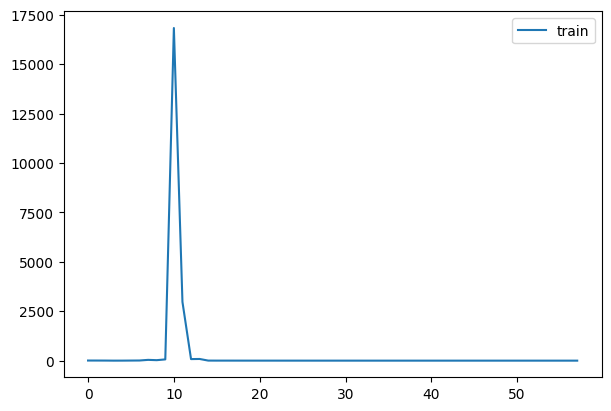

In [11]:
set_seed(1)
learn = fit(nn.Sequential(*cnn_layers()))

# hooks

## model insertion

In [9]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds = [[] for _ in layers]

    def __call__(self, x):
        for i, l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(to_cpu(x).mean())
            self.act_stds[i].append(to_cpu(x).std())
        return x

    def __iter__(self): return iter(self.layers)

err before_fit <callbacks.train_callback.TrainCB object at 0x75d286a116a0>
ok
ok
ok


err before_epoch <callbacks.train_callback.TrainCB object at 0x75d286a116a0>
err before_epoch <callbacks.device_callback.DeviceCB object at 0x75d2869ffa10>
ok
ok
err before_batch <callbacks.train_callback.TrainCB object at 0x75d286a116a0>
ok
err before_batch <callbacks.metrics_callback.MetricsCB object at 0x75d2869ffef0>
err before_batch <callbacks.progress_callback.ProgressCB object at 0x75d28694c470>
tensor([[-0.03, -0.04, -0.04,  ..., -0.02, -0.02, -0.03],
        [-0.03, -0.04, -0.03,  ..., -0.02, -0.03, -0.03],
        [-0.03, -0.04, -0.04,  ..., -0.02, -0.03, -0.03],
        ...,
        [-0.03, -0.04, -0.04,  ..., -0.02, -0.03, -0.03],
        [-0.03, -0.04, -0.04,  ..., -0.02, -0.03, -0.03],
        [-0.03, -0.04, -0.04,  ..., -0.02, -0.03, -0.03]], grad_fn=<ViewBackward0>)
ok
err predict <callbacks.device_callback.DeviceCB object at 0x75d2869ffa10>
err predict <callbacks.metrics_callback.MetricsCB object at 0x75d2869ffef0>
err predict <callbacks.progress_callback.ProgressCB ob

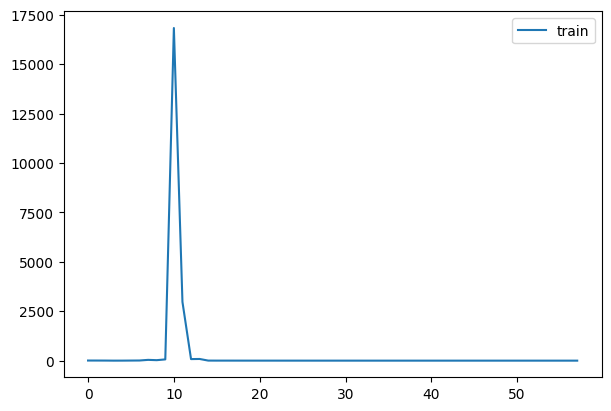

ok
err before_batch <callbacks.train_callback.TrainCB object at 0x75d286a116a0>
ok
err before_batch <callbacks.metrics_callback.MetricsCB object at 0x75d2869ffef0>
err before_batch <callbacks.progress_callback.ProgressCB object at 0x75d28694c470>
tensor([[ 0.67,  0.72,  0.72,  ..., -0.09, -0.09, -0.09],
        [ 0.67,  0.72,  0.72,  ..., -0.09, -0.09, -0.09],
        [ 0.67,  0.72,  0.72,  ..., -0.09, -0.09, -0.09],
        ...,
        [ 0.67,  0.72,  0.72,  ..., -0.09, -0.09, -0.09],
        [ 0.67,  0.72,  0.72,  ..., -0.09, -0.09, -0.09],
        [ 0.67,  0.72,  0.72,  ..., -0.09, -0.09, -0.09]], grad_fn=<ViewBackward0>)
ok
err predict <callbacks.device_callback.DeviceCB object at 0x75d2869ffa10>
err predict <callbacks.metrics_callback.MetricsCB object at 0x75d2869ffef0>
err predict <callbacks.progress_callback.ProgressCB object at 0x75d28694c470>
ok
err get_loss <callbacks.device_callback.DeviceCB object at 0x75d2869ffa10>
err get_loss <callbacks.metrics_callback.MetricsCB object

In [15]:
set_seed(1)
model = SequentialModel(*cnn_layers())
learn = fit(model)

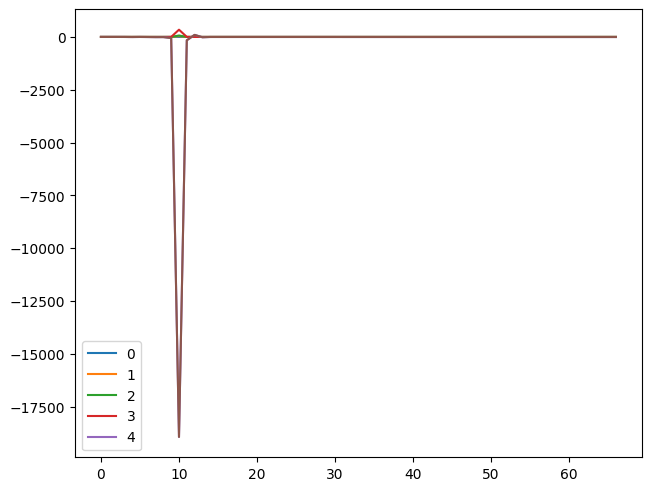

In [19]:
for l in model.act_means: plt.plot(l)
plt.legend(range(5))

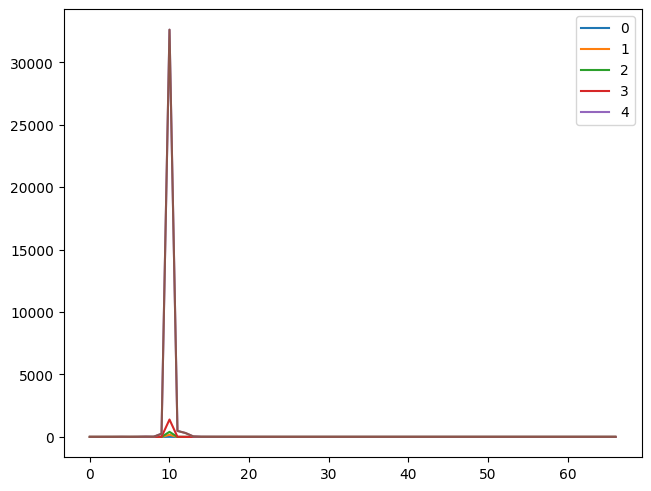

In [20]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(5))

## pytorch hooks

In [10]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

act_means = [[] for _ in model]
act_stds = [[] for _ in model]

def append_stats(i, mod, inp, outp):
    act_means[i].append(to_cpu(outp).mean())
    act_stds [i].append(to_cpu(outp).std())

In [11]:
for i,m in enumerate(model): m.register_forward_hook(partial(append_stats, i))

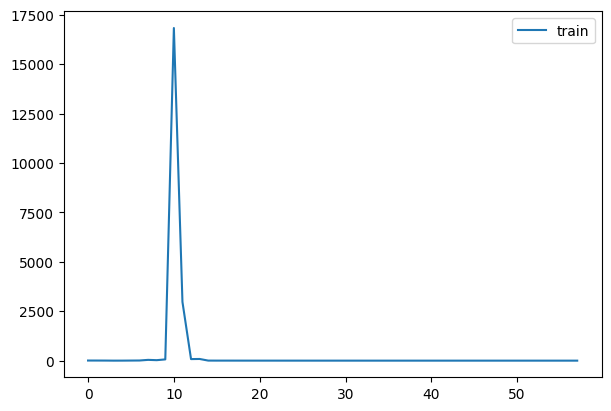

In [12]:
fit(model)

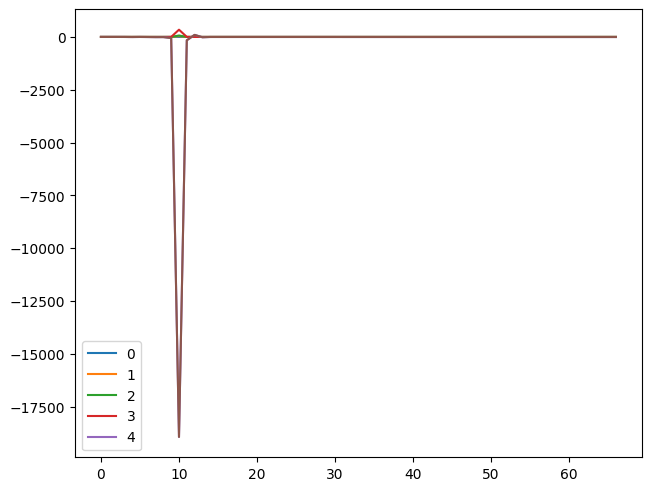

In [13]:
for o in act_means: plt.plot(o)
plt.legend(range(5))

## hook class

In [25]:
# need to export
class Hook():
    def __init__(self, model, function): self.hook = model.register_forward_hook(partial(function, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

def append_stats(hook, model, input, output):
    if not hasattr(hook, 'stats'): hook.stats = ([],[])
    acts = to_cpu(output)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())

In [26]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

In [27]:
hooks = [Hook(l, append_stats) for l in model[:5].children()]

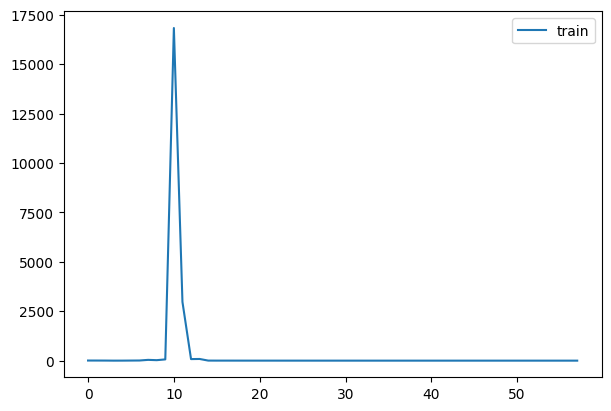

In [28]:
learn = fit(model)

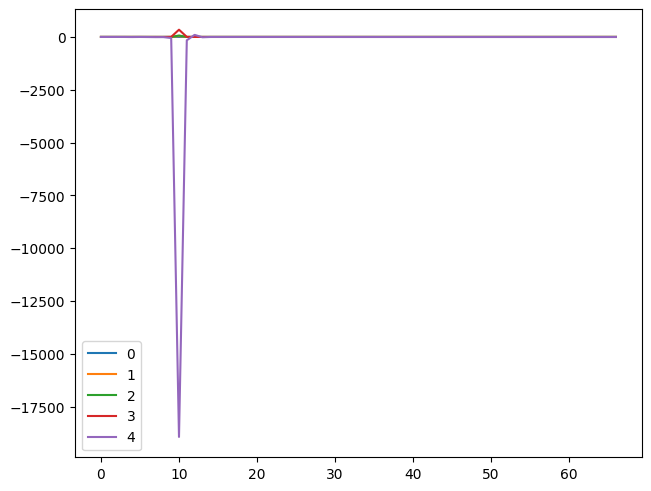

In [29]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(5))

## hooks class

In [30]:
class DummyCtsMgr:
    def __enter__(self, *args):
        print("let's go")
        return self
    def __exit__(self, *args): print("all done!")
    def hello(self): print('hello')

In [31]:
with DummyCtsMgr() as dcm: dcm.hello()

let's go
hello
all done!


In [32]:
class DummyList(list):
    def __delitem__(self, i):
        print(f"bye {i}")
        super().__delitem__(i)

In [36]:
dml = DummyList([1,2,3])
dml

[1, 2, 3]

In [38]:
del(dml[2])
dml

bye 2


[1, 2]

In [39]:
# export
class Hooks(list):
    def __init__(self, methods, func): super().__init__([Hook(m, func) for m in methods])
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.remove()
    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
    def remove(self):
        for h in self: h.remove()

In [40]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

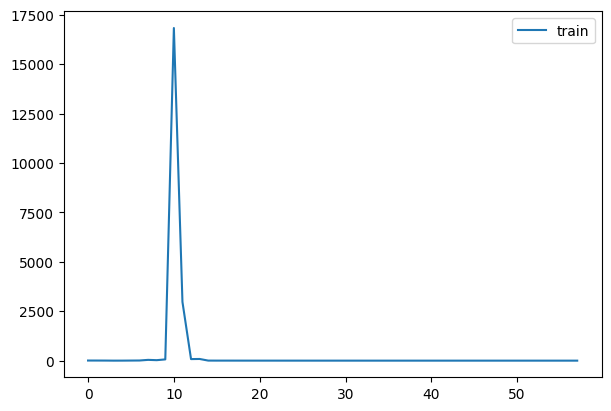

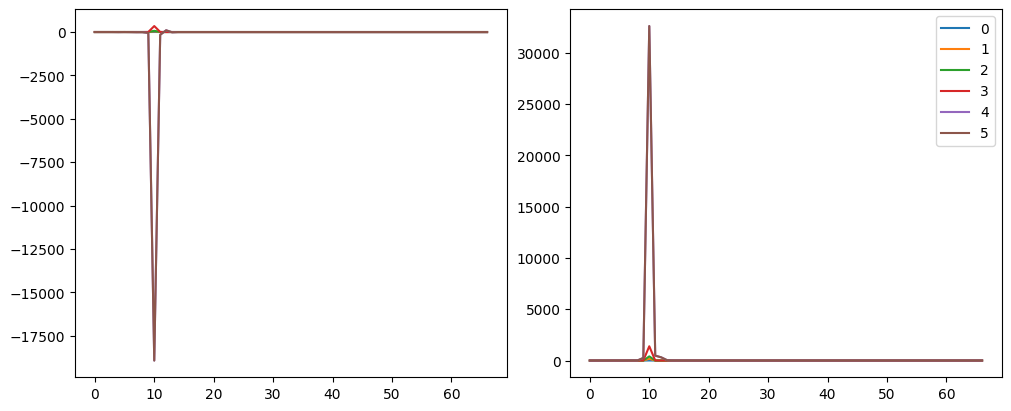

In [41]:
with Hooks(model, append_stats) as hooks:
    fit(model)
    fig, axs = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        for i in 0, 1: axs[i].plot(h.stats[i])
    plt.legend(range(6))